In [2]:
# monta driver
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# PLOT BOXPLOTS

## Carrega os dados

In [151]:
# copia dados
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes_mortes/*.csv .
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes-aqi_mortes/*.csv .
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes-aqi-temp-humid_mortes/*.csv .
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes-casos-aqi-temp-humid_mortes/*.csv .

In [152]:
ls

drive/
mortes-aqi_mortes_final_2021-07-10.csv
mortes-aqi_mortes_final_2021-07-10_saved_models_errors.csv
mortes-aqi_mortes_final_2021-07-10_test.csv
mortes-aqi_mortes_gs_2021-07-10.csv
mortes-aqi_mortes_gs_2021-07-10_test.csv
mortes-aqi-temp-humi_mortes_final_2021-07-13.csv
mortes-aqi-temp-humi_mortes_final_2021-07-13_test.csv
mortes-aqi-temp-humi_mortes_gs_2021-07-12.csv
mortes-aqi-temp-humi_mortes_gs_2021-07-12_test.csv
mortes-casos-aqi-temp-humid_mortes_gs_2021-07-10.csv
mortes-casos-aqi-temp-humid_mortes_gs_2021-07-10_test.csv
mortes-casos-aqi-temp-humi_mortes_final_2021-07-10.csv
mortes-casos-aqi-temp-humi_mortes_final_2021-07-10_test.csv
mortes_mortes_final_2021-07-13.csv
mortes_mortes_final_2021-07-13_test.csv
sample_data/


## Funções de plot

In [153]:
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import mean
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from keras.callbacks import EarlyStopping
import pandas as pd
import ast
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.constraints import maxnorm
from tensorflow import keras

In [154]:
def boxplot_experiments(data, key, n_repeats, max_value, min_value, dataset_name):
  random_dists = key

  fig, ax1 = plt.subplots(figsize=(5, 6))
  fig.canvas.manager.set_window_title('A Boxplot Example')
  fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

  bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
  plt.setp(bp['boxes'], color='black')
  plt.setp(bp['whiskers'], color='black')
  plt.setp(bp['fliers'], color='red', marker='+')

  ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)

  ax1.set(
      axisbelow=True,  # Hide the grid behind plot objects
      title='Average performance of %d models ' % n_repeats,
      xlabel='Model configurations',
      ylabel='RMSE - Deaths forecast (' + dataset_name + ')',
  )

  box_colors = ['darkkhaki', 'royalblue']
  num_boxes = len(data)
  medians = np.empty(num_boxes)
  for i in range(num_boxes):
      box = bp['boxes'][i]
      box_x = []
      box_y = []
      for j in range(5):
          box_x.append(box.get_xdata()[j])
          box_y.append(box.get_ydata()[j])
      box_coords = np.column_stack([box_x, box_y])
      # Alternate between Dark Khaki and Royal Blue
      ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
      # Now draw the median lines back over what we just filled in
      med = bp['medians'][i]
      median_x = []
      median_y = []
      for j in range(2):
          median_x.append(med.get_xdata()[j])
          median_y.append(med.get_ydata()[j])
          ax1.plot(median_x, median_y, 'k')
      medians[i] = median_y[0]
      # Finally, overplot the sample averages, with horizontal alignment
      # in the center of each box
      ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
              color='w', marker='*', markeredgecolor='k')

  # Due to the Y-axis scale being different across samples, it can be
  # hard to compare differences in medians across the samples. Add upper
  # X-axis tick labels with the sample medians to aid in comparison
  # (just use two decimal places of precision)
  pos = np.arange(num_boxes) + 1
  upper_labels = [str(round(s, 2)) for s in medians]
  weights = ['bold', 'semibold']
  for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
      k = tick % 2
      ax1.text(pos[tick], .95, upper_labels[tick],
              transform=ax1.get_xaxis_transform(),
              horizontalalignment='center', size='x-small',
              weight=weights[k], color=box_colors[k])

  # Set the axes ranges and axes labels
  ax1.set_xlim(0.5, num_boxes + 0.5)
  top = max(max(data))+max_value
  bottom = min(min(data))+min_value
  ax1.set_ylim(bottom, top)
  ax1.set_xticklabels(np.repeat(random_dists, 1),
                      rotation=0, fontsize=12)
  plt.rcParams.update({'font.size': 10})
  #ax1.set_aspect(0.01)
  
  x = dataset_name.split()
  name = 'boxplot_final_' + x[0] + '_' + x[1] + '.pdf'
  plt.savefig(name, dpi=100, bbox_inches='tight')
  plt.show()


def boxplot_experiments_best(scores_grid, n_best, n_repeats, max_value, min_value, plot_type):
  # get errors
  scores_list = list()
  scores_list_test = list()
  for key, cfg in scores_grid:
    scores = list()
    scores_test = list()
    for error, error_test in cfg:
      # erro de ajuste
      scores.append(error)
      # erro de predição
      scores_test.append(error_test)
    scores_list.append((key, scores))
    scores_list_test.append((key, scores_test))

  list_scores_list = list()
  i_list = None
  dataset_name = None

  if plot_type == 0:
    i_list = [scores_list]
    dataset_name = 'whole dataset'
  if plot_type == 1:
    i_list = [scores_list_test]
    dataset_name = 'test dataset'

  for list_score in i_list:
    # scores_list contém key da cfg e erros
    scores_array = np.array(list_score, dtype=object)
    scores_dict = dict(zip(scores_array[:,0], scores_array[:,1]))

    # sort configs by mean error
    config_averages = ((sum(scores) / len(scores), scores, s) for s, scores in scores_dict.items())

    score_list = list()
    key_list = list()
    average_list = list()

    for average, scores, config in sorted(config_averages, reverse=False):
      average_list.append(average)
      score_list.append(scores)
      key_list.append(config)

    boxplot_experiments(score_list[:n_best], key_list[:n_best], n_repeats, max_value, min_value, dataset_name)
    list_scores_list.append(score_list)

  return list_scores_list, key_list

## Plotar boxplot

In [159]:
def decode_exp_data(df_total, df_test):
  df_list = df_total.values.tolist()
  df2_list = df_test.values.tolist()
  final_list = list()

  for a, b in zip(df_list, df2_list):
    c = np.dstack([a[1:],b[1:]])
    c = c.reshape(c.shape[1], c.shape[2])
    c = c.tolist()
    final_list.append((a[0], c))

  return final_list

def load_data(dict_total, dict_test):
  df_error = pd.DataFrame(None)
  df_test = pd.DataFrame(None)

  for name_error, name_test in zip(dict_total, dict_test):
    tmp_error = read_csv(name_error)
    tmp_test = read_csv(name_test)
    df_error = df_error.append(tmp_error, ignore_index=True)
    df_test = df_test.append(tmp_test, ignore_index=True)

  #all_scores = decode_exp_data(df_error, df_test)

  return df_error, df_test

In [160]:
from pandas import read_csv
import numpy as np

dict_total = ['mortes_mortes_final_2021-07-13.csv', 'mortes-aqi_mortes_final_2021-07-10.csv', 'mortes-aqi-temp-humi_mortes_final_2021-07-13.csv', 'mortes-casos-aqi-temp-humi_mortes_final_2021-07-10.csv']
dict_test = ['mortes_mortes_final_2021-07-13_test.csv', 'mortes-aqi_mortes_final_2021-07-10_test.csv', 'mortes-aqi-temp-humi_mortes_final_2021-07-13_test.csv', 'mortes-casos-aqi-temp-humi_mortes_final_2021-07-10_test.csv']
names = ['D', 'D+A', 'D+A+T+H', 'D+C+A+T+H']

df_error, df_test = load_data(dict_total, dict_test)

for i in range(len(names)):
  df_error.at[i, 'Unnamed: 0'] = names[i]

all_scores = decode_exp_data(df_error, df_test)

In [ ]:
all_scores

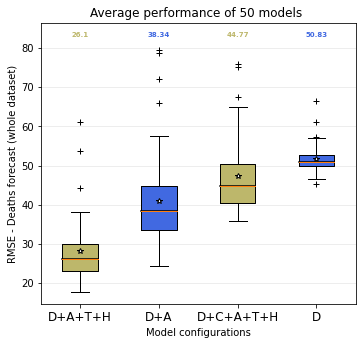

In [165]:
n_repeats = 10
plot_type = 0
score_list, key_list = boxplot_experiments_best(all_scores, 10, 50, 20, -3, plot_type)

In [ ]:
ls

In [166]:
!cp *.pdf /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/

# PLOT FORECASTS

### Forecast functions

In [209]:
# evaluate a single model
def forecast_model(model, data, n_test, cfg):
  n_input, *_, type_norm = cfg
  if type_norm != None: 
    data_norm, scaler = normalize_data(data, type_norm)
  else:
    data_norm = data
    scaler = None
  train, test = split_dataset(data_norm, n_test, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)

  # 'desnormaliza' dados, caso necessário
  if type_norm != None:
    shape = predictions.shape
    predictions = desnormalize_data(predictions, scaler)
    predictions = predictions.reshape(shape[0], shape[1])
    shape = test.shape
    test = test[:, :, 0].flatten()
    test = desnormalize_data(test, scaler)
    test = test.reshape(shape[0], shape[1])

  if type_norm == None:
    test = test[:, :, 0]

  # retorna a primeira feature, e a predição
  return test[:,:], predictions

# split a univariate dataset into train/test sets
# recebe os dados como um array onde as linhas são os timesteps e as colunas são as features
def split_dataset(data, n_test, n_days):
  # makes dataset multiple of n_days
  data = data[data.shape[0] % n_days:]
  # make test set multiple of n_days
  n_test -= n_test % n_days
  # split into standard weeks
  train, test = data[:-n_test], data[-n_test:]
  # restructure into windows of weekly data
  train = array(split(train, len(train)/n_days))
  test = array(split(test, len(test)/n_days))
  return train, test

# make a forecast
def forecast(model, history, config):
  n_input, *_ = config
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, 1:]
  # reshape into [1, n_input, 1]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# grid search configs
def normalize_data(data, type_norm):
  scaler = None
  norm_data = np.array([])
  if not type_norm:
    return data, None

  if type_norm == 'MinMax':
    samples = data.shape[0]
    columns = data.shape[1]
    data_ = data.flatten(order='A')
    data_ = data_.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaler.fit(data_)
    data_ = scaler.fit_transform(data_)
    for i in range(columns):
      a = data_[i*samples:(i+1)*samples]
      if norm_data.shape[0] == 0:
        norm_data = a
      else:
        norm_data = np.hstack((norm_data, a))
  return norm_data, scaler

# grid search configs
def desnormalize_data(data, scaler):
  data_ = data.flatten()
  data_ = scaler.inverse_transform(data_.reshape(-1,1))
  return data_

### Plot functions

In [172]:
# plotar os melhores modelos encontrados
def plot_predictions(models, data, n_models, n_test, date_, t_average, experiment, toPDF, desired_plot):

  # array com todos os caras ordenados
  for model, i_plt in zip(models[:n_models], range(1, len(models[:n_models])+1)):
    model_ = model[2]
    cfg_array = model[1]
    cfg_ = str(cfg_array)
    n_input = cfg_array[0]
    
    # forecast_model
    test, predictions = forecast_model(model_, data, data.shape[0]-n_input, cfg_array)
    predictions = predictions.flatten()
    predictions = predictions.reshape(-1,1)
    test = test.flatten()
    test = test.reshape(-1,1)

    # faz cópia pq python ResidentSleeper
    date = date_.copy()

    date = date[:test.shape[0]]

    x_tick = list()
    # 10 datas no eixo x (9 + a ultima)
    n_ticks = np.ceil(date.shape[0]/9)

    for i in range(date.shape[0]):
      if i % n_ticks == 0:
        x_tick.append(date[i])
    x_tick.append(date[-1])

   # monta a série de mortes acumuladas da predição
    predictions_acc = moving_average_to_acc(predictions, t_average)
    test_acc = moving_average_to_acc(test, t_average)

    error_acc = (-test_acc[-1] + predictions_acc[-1]) * 100 / test_acc[-1]

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(date, test, label='Real Data')
    plt.plot(date, predictions, label='Predicted')
    plt.axvspan(test.shape[0]-n_test, test.shape[0]-1, color='red', alpha=0.1)
    plt.xlabel("Days")
    plt.ylabel("Biweekly moving average of COVID-19 deaths")
    plt.title("Forecast of model with error (%.2f, %.2f) from config " % (model[0], model[4]) + cfg_ + " for " + experiment)
    plt.legend()
    plt.xticks(x_tick)
    plt.grid()
    plt.rcParams.update({'font.size': 12})

    if toPDF & (i_plt == desired_plot):
      name = 'forecast_final_' + experiment + '.pdf'
      plt.savefig(name, dpi=100, bbox_inches='tight')

    plt.show()


    

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(date, test_acc, label='Real Data')
    plt.plot(date, predictions_acc, label='Predicted')
    plt.axvspan(test_acc.shape[0]-n_test, test_acc.shape[0]-1, color='red', alpha=0.1)
    plt.xlabel("Days")
    plt.ylabel("Accumulated COVID-19 deaths")
    plt.title("Accumulated Forecast with error %.2f %% from config " % error_acc + cfg_ + " for " + experiment)
    plt.legend()
    plt.xticks(x_tick)
    plt.grid()
    plt.rcParams.update({'font.size': 12})

    if toPDF & (i_plt == desired_plot):
      name = 'accumulated_final_' + experiment + '.pdf'
      plt.savefig(name, dpi=100, bbox_inches='tight')

    plt.show()

def moving_average_to_acc(data, t_average):
  # transforma em dataframe pra facilitar
  df_data = pd.DataFrame(data=data[:,0], columns=['deaths'])
  # tem q fazer essa cópia senão ele modifica a variável global data LOL
  df_data = df_data.copy()

  flag = False

  for i in range(0, data.shape[0]-1):
    sum = 0
    if i >= t_average-1:
      for j in range(1,t_average):
        sum = sum + df_data['deaths'][i-j]
      # passa de média móvel semanal para dados diários
      df_data['deaths'][i] = df_data['deaths'][i+1]*t_average - sum
      # check if theres negative numbers (sometimes this happens if the model is bad)
      if df_data['deaths'][i+1]*t_average < sum:
        flag = True
  # acumula as mortes diárias
  df_data["deaths"] = df_data["deaths"].cumsum()
  # ajusta
  df_data['deaths'] = df_data['deaths'].shift(periods=1)
  # remove nans
  df_data['deaths'] = df_data['deaths'].fillna(0)
  # filter acc data from bad model (avoid weird behavior)
  if flag:
    df_data['deaths'] = savgol_filter(df_data['deaths'].values, 71, 2)
    #df_data['deaths'] = medfilt(df_data['deaths'].values, 301)
  return df_data['deaths'].values

In [173]:
for i in range(1,5+1):
  print(i)

1
2
3
4
5


## The rest

In [174]:
# load data
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_mob/dataframes/*_pred.csv .

In [175]:
# load models
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes_mortes/models/* .
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes-aqi_mortes/models/* .
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes-aqi-temp-humid_mortes/models/* .
!cp /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/mortes-casos-aqi-temp-humid_mortes/models/* .

In [176]:
df = read_csv('df_spsp_pred.csv')

dict_cases = ['D', 'D+A', 'D+A+T+H', 'D+C+A+T+H']
data_list = list()

for case in dict_cases:
  tmp = None
  if case == 'D':
    tmp = [df['deaths'].values, df['deaths'].values]
  if case == 'D+A':
    tmp = [df['deaths'].values, df['deaths'].values, df['aqi'].values]
  if case == 'D+A+T+H':
    tmp = [df['deaths'].values, df['deaths'].values, df['aqi'].values, df['temperature'].values, df['humidity'].values]
  if case =='D+C+A+T+H':
    tmp = [df['deaths'].values, df['deaths'].values, df['cases'].values, df['aqi'].values, df['temperature'].values, df['humidity'].values]
  
  tmp = array(tmp).T
  data_list.append(tmp)

print(data_list[0].shape)

(446, 2)


In [177]:
ls

boxplot_final_test_dataset.pdf
boxplot_final_whole_dataset.pdf
df_brasil_pred.csv
df_rj_pred.csv
df_rjrj_pred.csv
df_sp_pred.csv
df_spsp_pred.csv
drive/
mortes-aqi_mortes_final_2021-07-10_0.h5
mortes-aqi_mortes_final_2021-07-10_1.h5
mortes-aqi_mortes_final_2021-07-10_2.h5
mortes-aqi_mortes_final_2021-07-10_3.h5
mortes-aqi_mortes_final_2021-07-10_4.h5
mortes-aqi_mortes_final_2021-07-10_5.h5
mortes-aqi_mortes_final_2021-07-10_6.h5
mortes-aqi_mortes_final_2021-07-10_7.h5
mortes-aqi_mortes_final_2021-07-10_8.h5
mortes-aqi_mortes_final_2021-07-10_9.h5
mortes-aqi_mortes_final_2021-07-10.csv
mortes-aqi_mortes_final_2021-07-10_saved_models_errors.csv
mortes-aqi_mortes_final_2021-07-10_test.csv
mortes-aqi_mortes_gs_2021-07-10.csv
mortes-aqi_mortes_gs_2021-07-10_test.csv
mortes-aqi-temp-humi_mortes_final_2021-07-13_0.h5
mortes-aqi-temp-humi_mortes_final_2021-07-13_1.h5
mortes-aqi-temp-humi_mortes_final_2021-07-13_2.h5
mortes-aqi-temp-humi_mortes_final_2021-07-13_3.h5
mortes-aqi-temp-humi_mortes_

In [193]:
# montar a estrutura do models (lista de listas com [erro total, configuração, modelo, None, erro de predicao] em cada posicao)
plot_list = list()
models_list = list()
models_err_list = list()
df_final_list = list()

dict_total = ['mortes_mortes_final_2021-07-13', 'mortes-aqi_mortes_final_2021-07-10', 'mortes-aqi-temp-humi_mortes_final_2021-07-13', 'mortes-casos-aqi-temp-humi_mortes_final_2021-07-10']

# load models from h5 file
for name in dict_total:
  tmp_ = list()
  df_models_err = read_csv(name + '_saved_models_errors.csv')
  df_final = read_csv(name + '.csv')
  for i in range(10):
    model = keras.models.load_model(name + '_' + str(i) + '.h5')
    tmp_.append(model)
  models_list.append(tmp_)
  models_err_list.append(df_models_err)
  df_final_list.append(df_final)

In [195]:
len(models_list)

4

In [188]:
models_err_list[1].at[0, '0']

24.35743307285145

In [190]:
df_final_list[1].at[0, 'Unnamed: 0']

'[7, 100, 500, 16, 0.0, None]'

In [197]:
for model_list, j in zip(models_list, range(len(models_list))):
  tmp_ = list()
  df_err = models_err_list[j]
  df_final = df_final_list[j]
  for model, i in zip(model_list, range(len(model_list))):
    tmp_.append([df_err.at[i, '0'], ast.literal_eval(df_final.at[0, 'Unnamed: 0']), model, None, df_err.at[i, '1']])
  plot_list.append(tmp_)

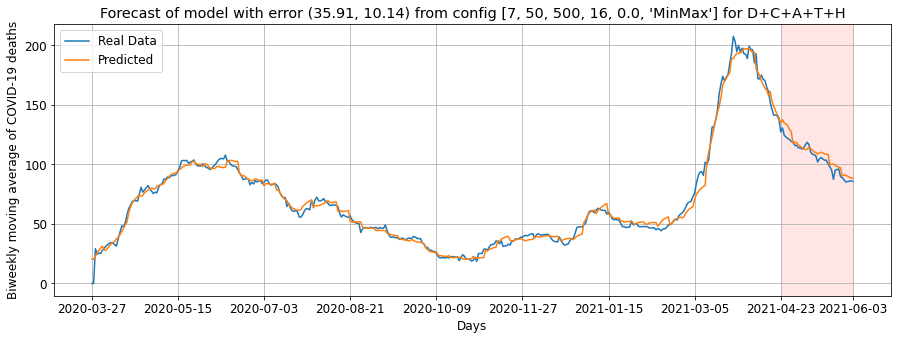

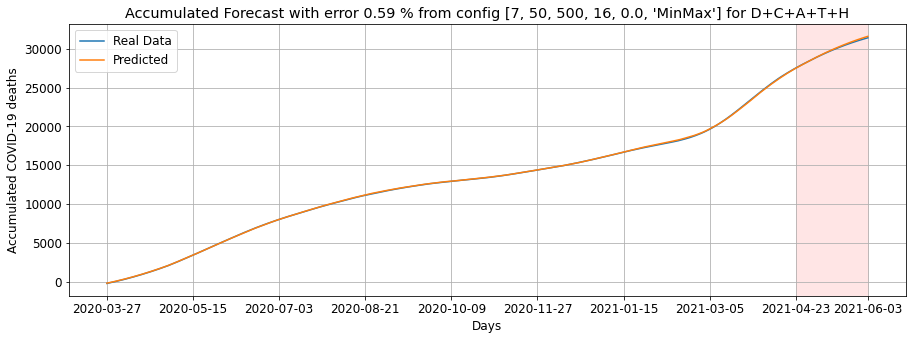

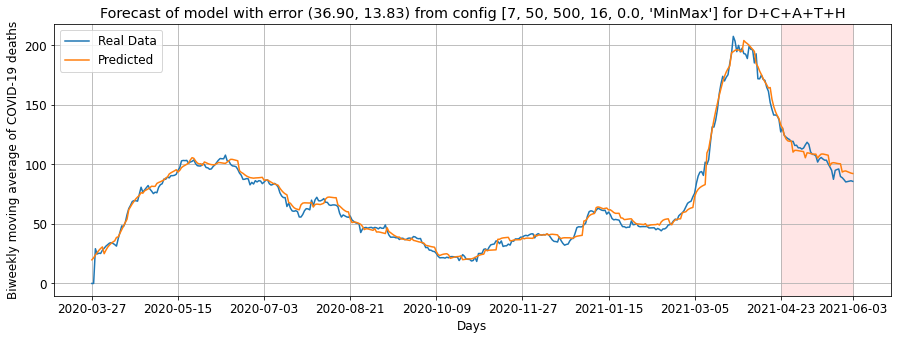

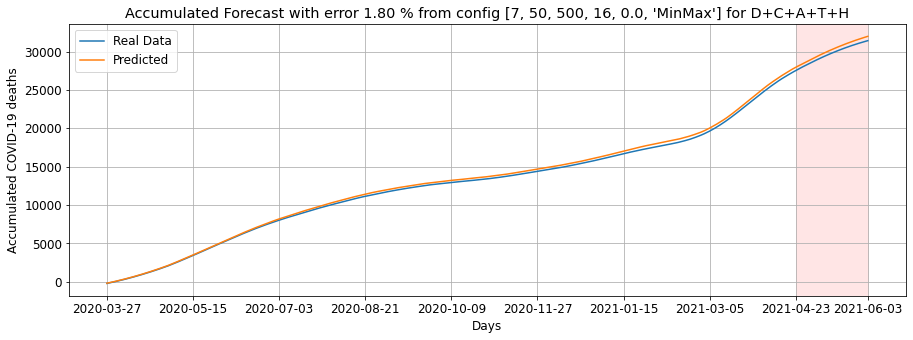

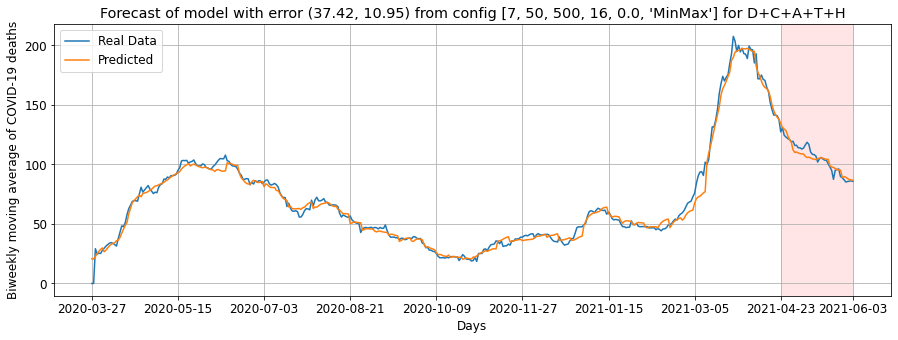

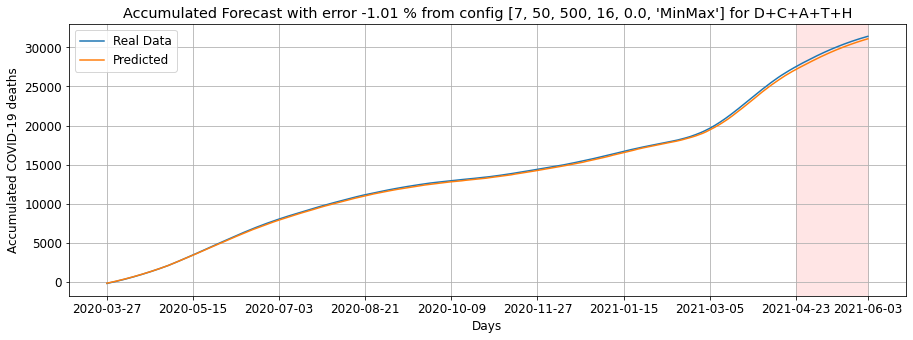

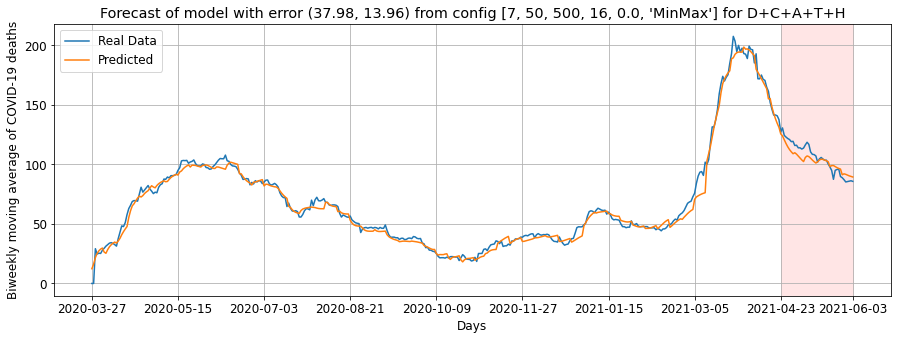

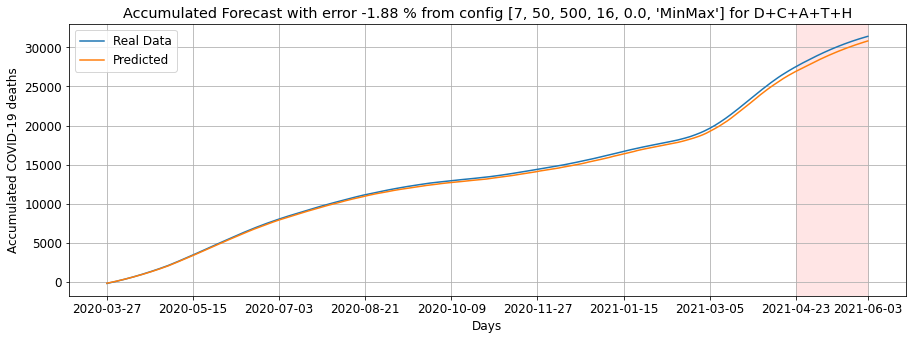

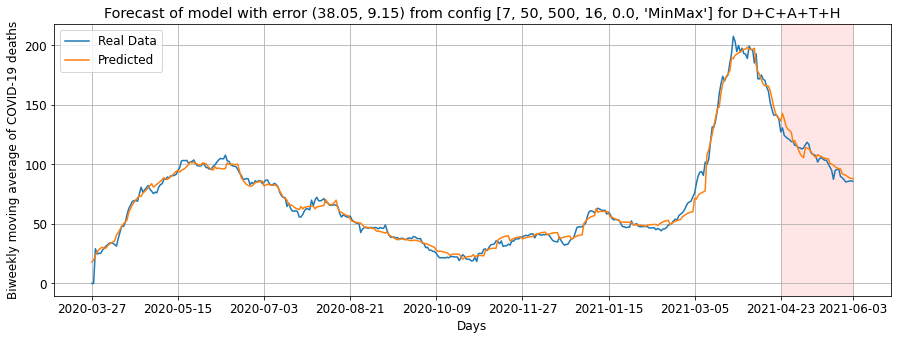

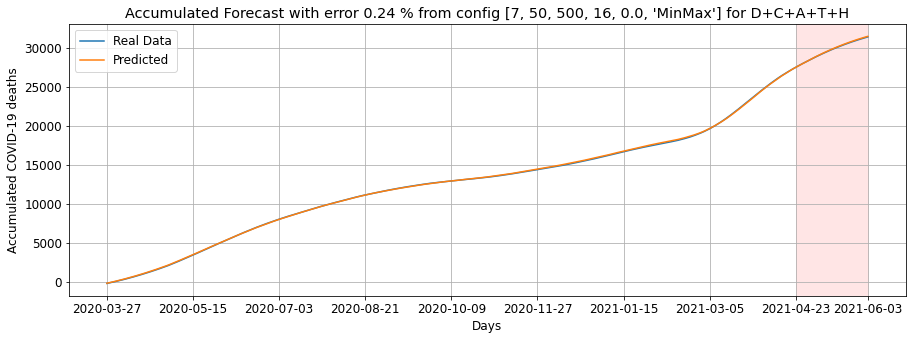

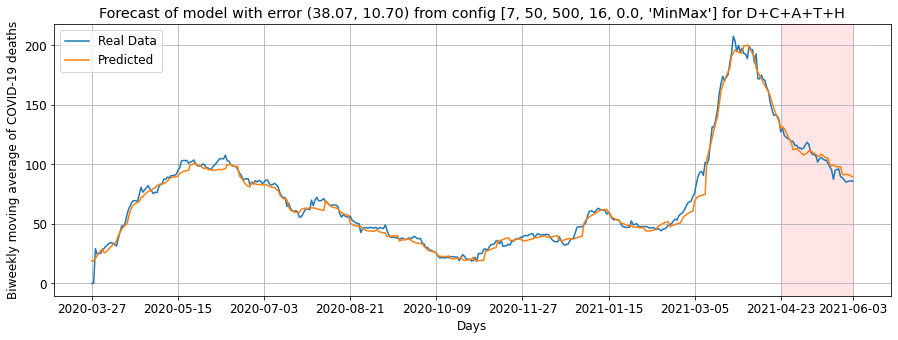

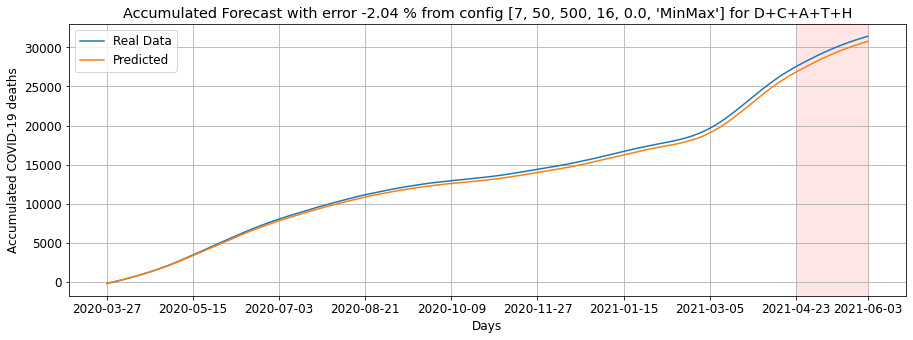

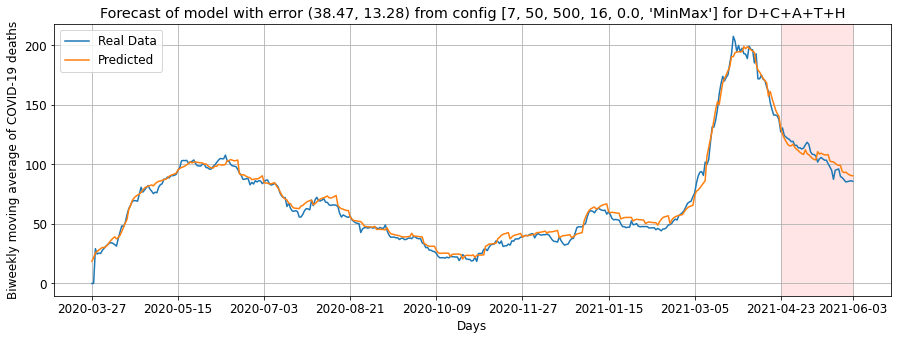

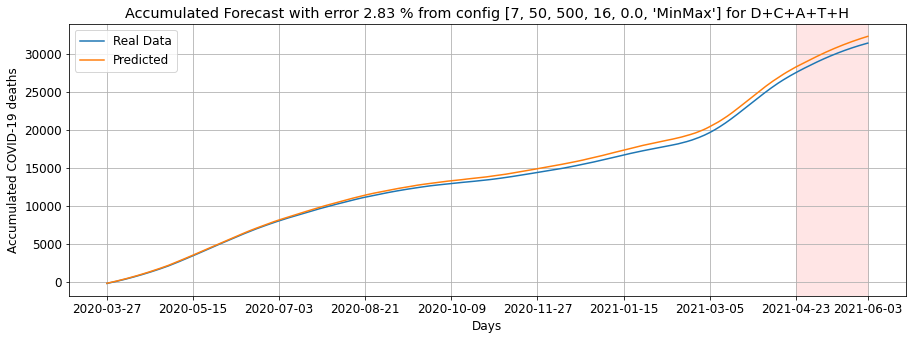

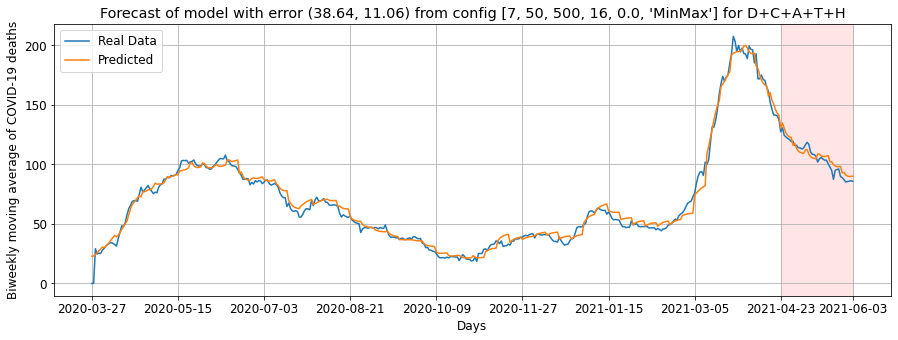

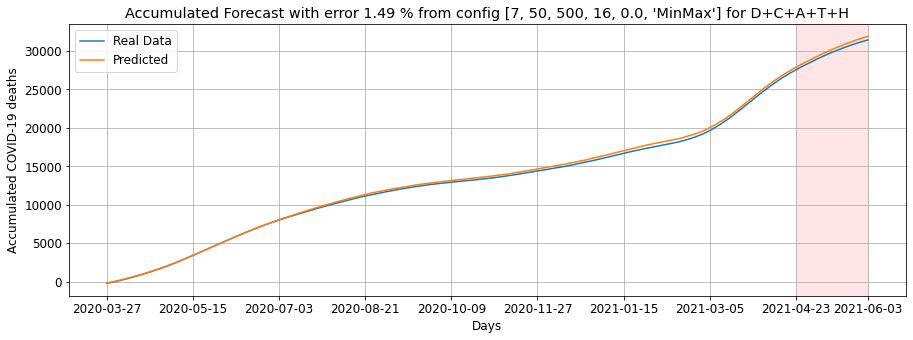

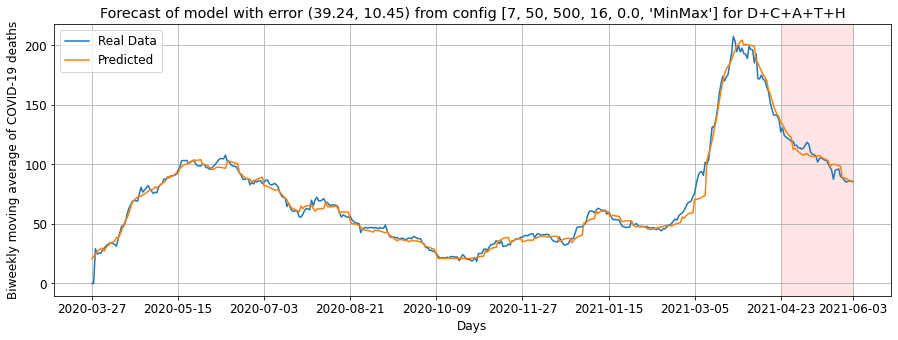

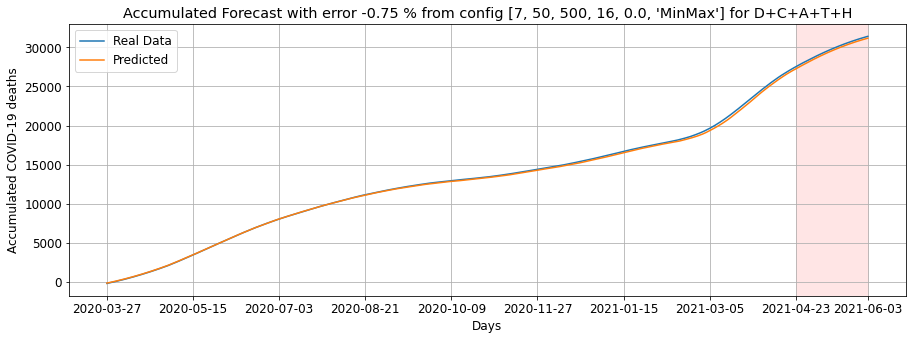

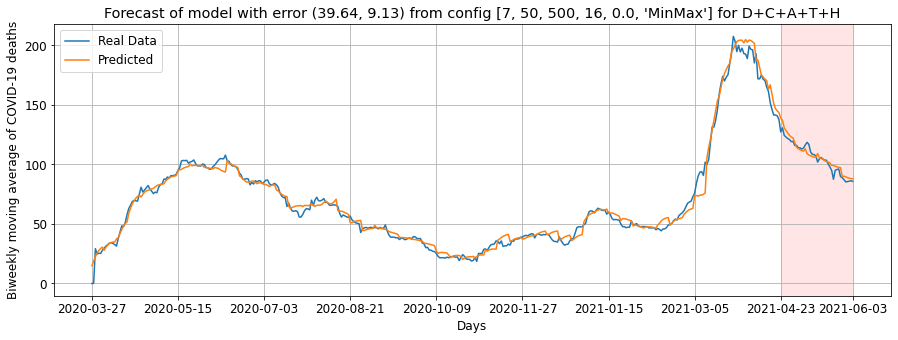

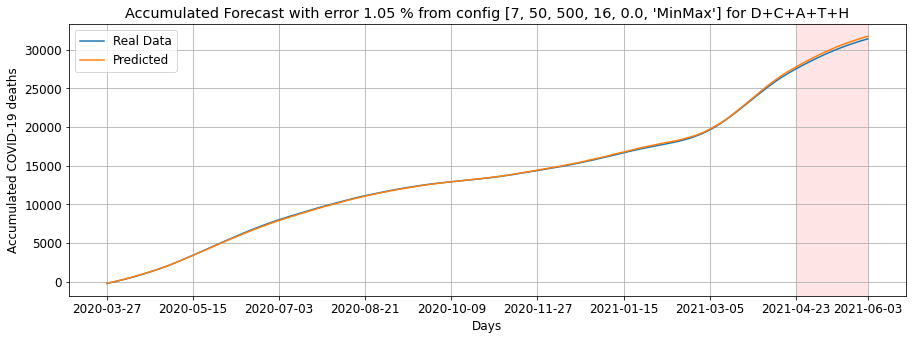

In [211]:
n_test = 7*6
experiment = 3
toPDF = 1
desired_plot = 1

plot_predictions(plot_list[experiment], data_list[experiment], len(plot_list[experiment]), n_test, df['date'].values, 14, dict_cases[experiment] , toPDF, desired_plot)

In [136]:
rm *.pdf

In [212]:
!cp *.pdf /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/

In [202]:
ls

accumulated_final_D+A+T+H.pdf
accumulated_final_D.pdf
boxplot_final_test_dataset.pdf
boxplot_final_whole_dataset.pdf
df_brasil_pred.csv
df_rj_pred.csv
df_rjrj_pred.csv
df_sp_pred.csv
df_spsp_pred.csv
drive/
forecast_final_D+A+T+H.pdf
forecast_final_D.pdf
mortes-aqi_mortes_final_2021-07-10_0.h5
mortes-aqi_mortes_final_2021-07-10_1.h5
mortes-aqi_mortes_final_2021-07-10_2.h5
mortes-aqi_mortes_final_2021-07-10_3.h5
mortes-aqi_mortes_final_2021-07-10_4.h5
mortes-aqi_mortes_final_2021-07-10_5.h5
mortes-aqi_mortes_final_2021-07-10_6.h5
mortes-aqi_mortes_final_2021-07-10_7.h5
mortes-aqi_mortes_final_2021-07-10_8.h5
mortes-aqi_mortes_final_2021-07-10_9.h5
mortes-aqi_mortes_final_2021-07-10.csv
mortes-aqi_mortes_final_2021-07-10_saved_models_errors.csv
mortes-aqi_mortes_final_2021-07-10_test.csv
mortes-aqi_mortes_gs_2021-07-10.csv
mortes-aqi_mortes_gs_2021-07-10_test.csv
mortes-aqi-temp-humi_mortes_final_2021-07-13_0.h5
mortes-aqi-temp-humi_mortes_final_2021-07-13_1.h5
mortes-aqi-temp-humi_morte